In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from KDEpy import TreeKDE
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## a) Explore the data using suitable methods and tools.

In [2]:
data = pd.read_csv('data_KDE_2D.csv')
data_array = data.to_numpy()
data

,X,Y
0,5.336130,8.064160
1,0.293243,3.939345
2,0.033378,2.282810
3,0.646273,1.968270
4,5.119659,3.580912
...,...,...
95,4.874246,5.170647
96,0.048707,-0.307987
97,0.278910,3.251409
98,5.023713,4.360683


Data Describe:
                 X           Y
count  100.000000  100.000000
mean     2.778562    4.028618
std      2.110978    1.525876
min      0.030321   -0.307987
25%      0.813366    3.072323
50%      2.475870    3.956257
75%      4.701586    5.129715
max      7.672813    8.064160

Data Head:
           X         Y
0  5.336130  8.064160
1  0.293243  3.939345
2  0.033378  2.282810
3  0.646273  1.968270
4  5.119659  3.580912


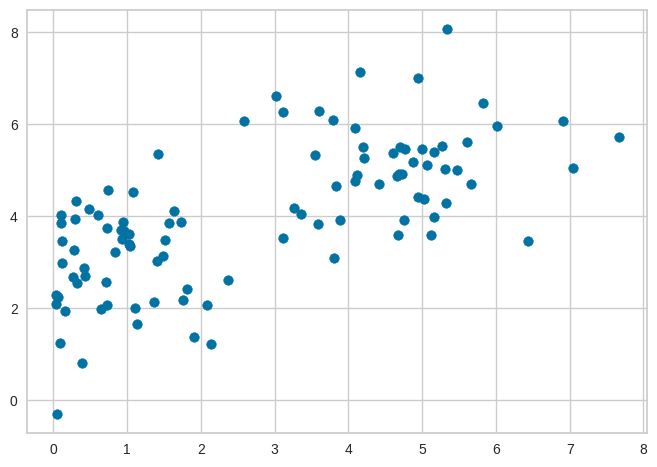

In [3]:
print("Data Describe:\r\n", data.describe())
print("\r\nData Head:\r\n", data.head())

xval = np.arange(len(data.index))
plt.scatter(data['X'], data['Y'])

## b) Group the data to generate a meaningful histogram of the data

#### Find an appropriate k for KMeans clustering: Method seen at [towardsdatascience](https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d)

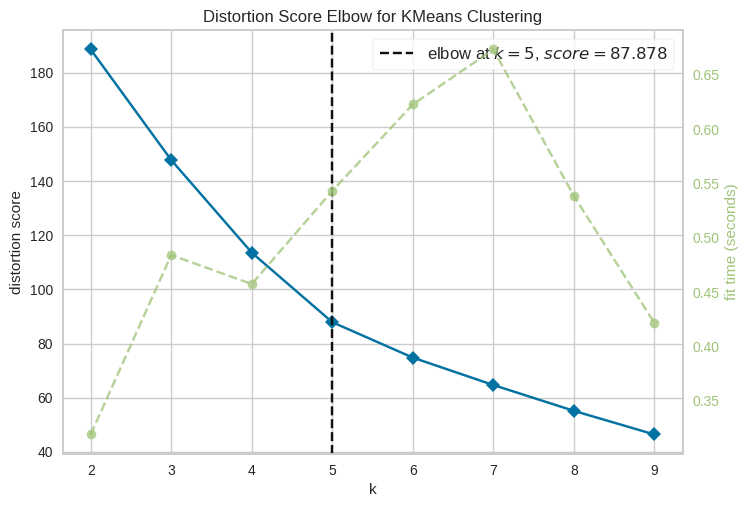

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
# Instantiate the clustering model and visualizer
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2, 10))

visualizer.fit(data)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

### No clear elbow point can be found! Let's try the silhouette method. (Observing datapoints by eye: k should be around 2)

'\nThe following conditions should be checked to pick the right ‘K’ using the Silhouette plots:\n\n1.  For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line).\n    The x-axis represents the Silhouette score. (Hold for all cluster!)\n2.  There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points.\n    For K = 2, the best fit is shown, since other ks vary in size\n'

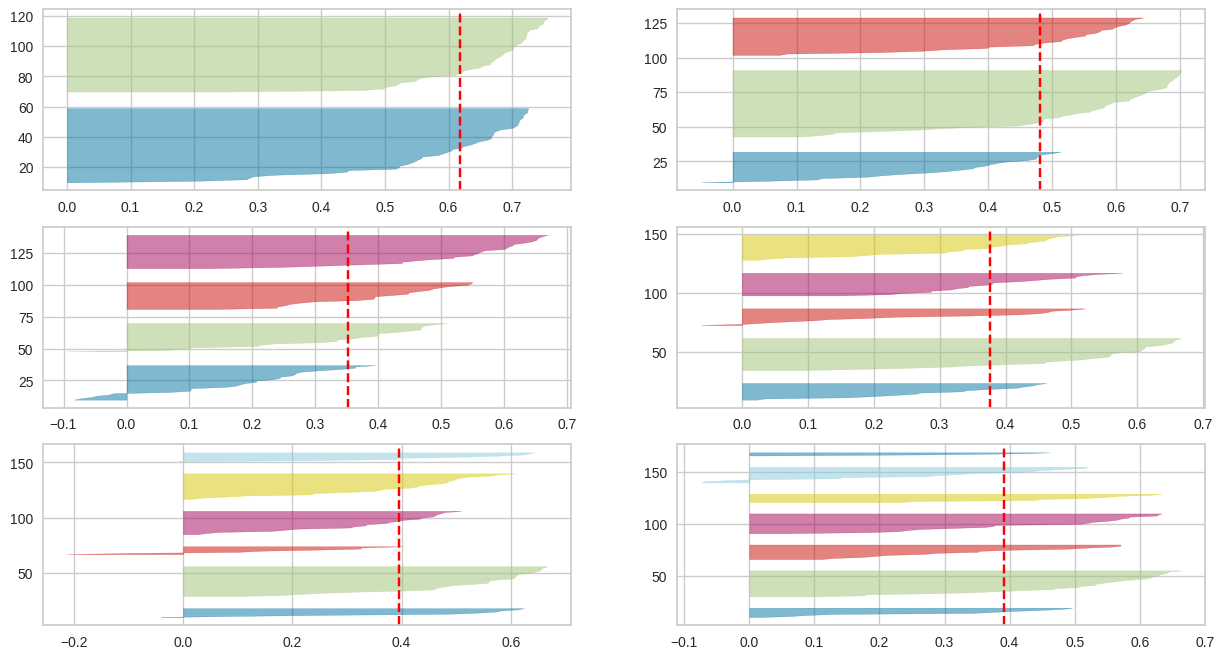

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(data)

"""
The following conditions should be checked to pick the right ‘K’ using the Silhouette plots:

1.  For a particular K, all the clusters should have a Silhouette score more than the average score of the dataset (represented by a red dotted line).
    The x-axis represents the Silhouette score. (Hold for all cluster!)
2.  There should not be wide fluctuations in the size of the clusters. The width of the clusters represents the number of data points.
    For K = 2, the best fit is shown, since other ks vary in size
"""

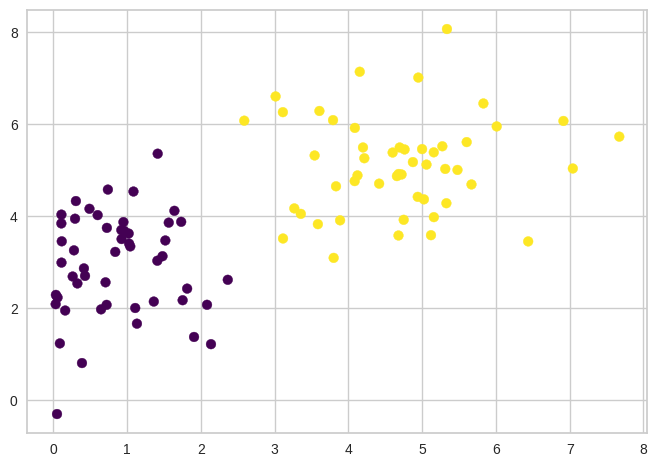

In [6]:
# So take k=2
# Now we can perform kmean clustering...
kmean = KMeans(n_clusters=2).fit(data)

# ... which will generate one label for each data point
labels = kmean.predict(data)
data['label'] = labels
plt.scatter(data['X'], data['Y'], cmap='viridis', c=labels)
plt.show()

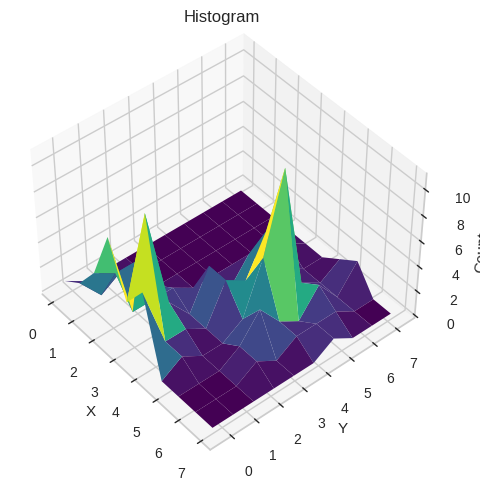

In [7]:
% matplotlib notebook
x = data['X']
y = data['Y']

# Generate 2D histogram (H contains the count)
H, xedges, yedges = np.histogram2d(x, y, bins=10)

# Create 3D plot
X, Y = np.meshgrid(xedges, yedges)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Count')
ax.set_title('Histogram')
ax.plot_surface(X[:-1, :-1], Y[:-1, :-1], H, cmap='viridis')
ax.view_init(elev=45, azim=320)

plt.show()

## c) Try to fit a normal distribution into the data. Plot the surface and contours of the fitted normal distribution on top of the data points.

In [8]:
# According to the hint we should calculate the covariance matrix:
cov = np.cov(data_array, bias=True)
#cov

# We have to calculate the covariance matrices twice since we also have to groups that need to be fed
cov0 = np.diag([1., 1.])
data0 = data[data["label"] == 0]
xvar0 = np.var(data0.iloc[:, 0])
yvar0 = np.var(data0.iloc[:, 1])
cov0[0][0] = xvar0
cov0[1][1] = yvar0

cov1 = np.diag([1., 1.])
data1 = data[data["label"] == 1]
xvar1 = np.var(data1.iloc[:, 0])
yvar1 = np.var(data1.iloc[:, 1])
cov1[0][0] = xvar1
cov1[1][1] = yvar1

In [9]:
# According to the hint we should calculate the mean vector.
meanx0 = np.mean(data0["X"])
meany0 = np.mean(data0["Y"])

meanx1 = np.mean(data1["X"])
meany1 = np.mean(data1["Y"])

In [10]:
# Now we are able to calculate the PDF of the multivariate normal distribution
rv0 = multivariate_normal([meanx0, meany0], cov0)
pos0 = np.dstack((X, Y))
z0 = rv0.pdf(pos0)

rv1 = multivariate_normal([meanx1, meany1], cov1)
pos1 = np.dstack((X, Y))
z1 = rv1.pdf(pos1)

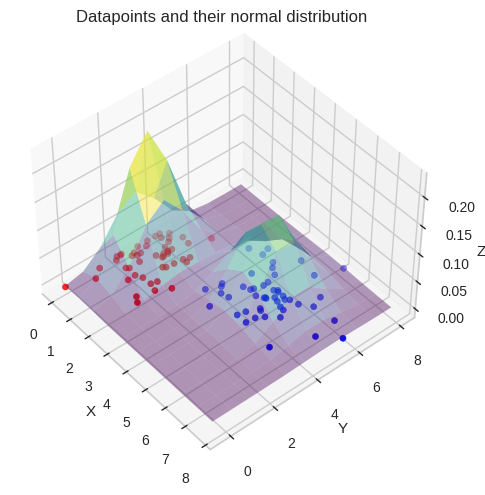

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Datapoints and their normal distribution')

# Combine both multivariate NDs
z = z0 + z1

ax.scatter(data0["X"], data0["Y"], c="red")
ax.scatter(data1["X"], data1["Y"], c="blue")
ax.plot_surface(X, Y, z, cmap='viridis', alpha=0.4)

ax.view_init(elev=45, azim=320)

plt.show()

## d) Multivariate kernel density estimation: Put a kernel (Gaussian, box, triangular) on top of every data point. Discuss the results.

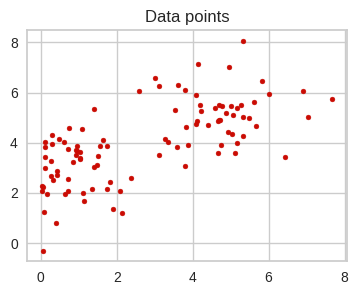

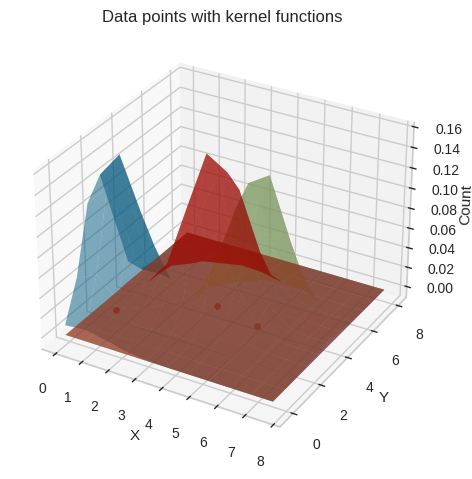

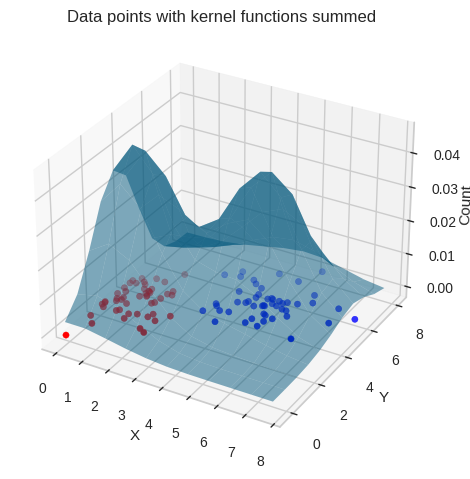

In [12]:
# Plot the points
plt.figure(figsize=(14, 3));
plt.subplot(1, 3, 1)
plt.title('Data points')
plt.scatter(data['X'], data['Y'], marker='.', c='r', label='Data')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Count')
ax.set_title('Data points with kernel functions')

# We are using less points to make the principle more visible
for i in range(3, 6):
    ax.scatter(data.iloc[i]['X'], data.iloc[i]['Y'], c='red')

    # Use a Gaussian kernel
    tree_kde = TreeKDE(kernel='gaussian')
    # fit the model on the 2D data
    tree_kde.fit(data=np.array(data.iloc[i][['X', 'Y']]).reshape(1, 2))

    # evaluate the density estimate at a set of points
    grid_points = np.column_stack((X.ravel(), Y.ravel()))
    density = tree_kde.evaluate(grid_points)
    ax.plot_surface(X, Y, density.reshape(11, 11), alpha=0.5)
plt.show()

# create TreeKDE object for the entire data
tree_kde = TreeKDE(kernel='gaussian')
# fit the model on the 2D data
tree_kde.fit(data=np.array(data[['X', 'Y']]))

grid_points = np.column_stack((X.ravel(), Y.ravel()))
density = tree_kde.evaluate(grid_points)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Count')
ax.set_title('Data points with kernel functions summed')
ax.scatter(data0["X"], data0["Y"], c="red")
ax.scatter(data1["X"], data1["Y"], c="blue")
ax.plot_surface(X, Y, density.reshape(11, 11), alpha=0.5)
plt.show()

## e) Vary the parameters of the kernels (bandwidth, weights, ...) used in (d) and combine them to get a KDE.
# Gaussian Kernel - Play with bandwidth

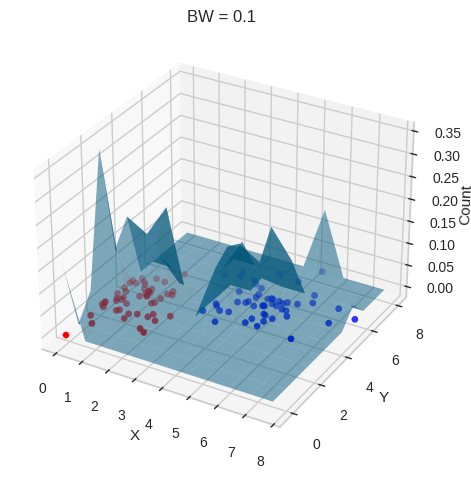

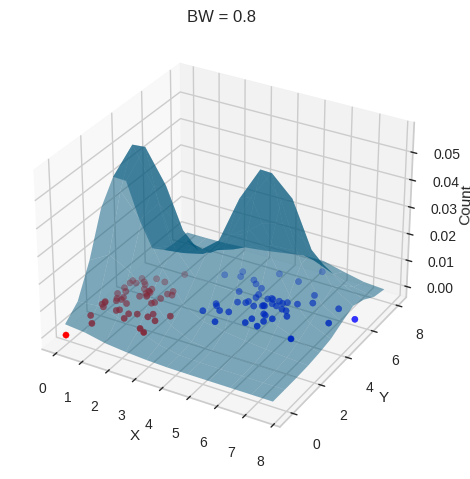

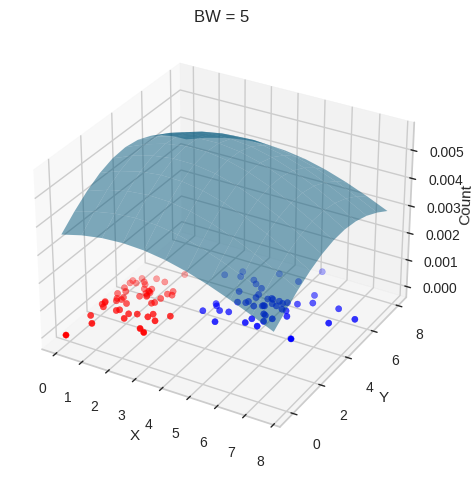

In [13]:
from sklearn.neighbors import KernelDensity

# Try a few different bandwiths
for bw in [0.1, 0.8, 5]:
    # create the kernel density estimator
    kde = KernelDensity(kernel='gaussian', metric='euclidean', algorithm='kd_tree', bandwidth=bw)
    kde.fit(data[['X', 'Y']].to_numpy())

    grid_points = np.column_stack((X.ravel(), Y.ravel()))
    density = np.exp(kde.score_samples(grid_points))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Count')
    ax.set_title('BW = {}'.format(bw))
    ax.scatter(data0["X"], data0["Y"], c="red")
    ax.scatter(data1["X"], data1["Y"], c="blue")
    ax.plot_surface(X, Y, density.reshape(11, 11), alpha=0.5, label=bw)
    plt.show()

# Gaussian Kernel - Play with weights

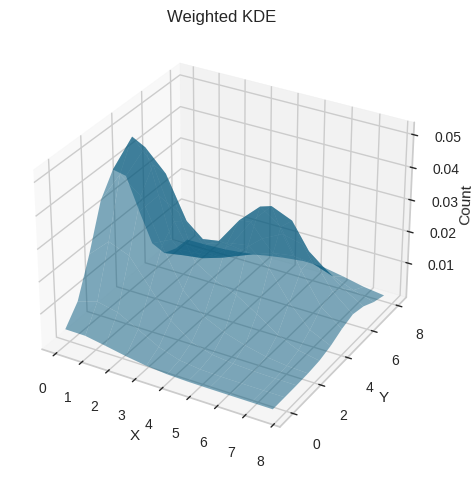

In [14]:
data_array = data[['X', 'Y']].to_numpy()
np.random.seed(36)
weights = np.random.randint(0, 1000, 100)

# create the kernel density estimator
kde = KernelDensity(kernel='gaussian', metric='euclidean', algorithm='kd_tree')
# Attach weights to the datapoints
kde.fit(data_array, sample_weight=weights)

grid_points = np.column_stack((X.ravel(), Y.ravel()))
density = np.exp(kde.score_samples(grid_points))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Count')
ax.set_title('Weighted KDE')
ax.plot_surface(X, Y, density.reshape(11, 11), alpha=0.5, label=bw)
plt.show()

##### You can see that the second "hill" is much lower than in the unweighted KDE (see above)